In [1]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.optimizers import Adam


from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [2]:
main_folder = '../input/celeba-dataset/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000506.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [3]:
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [4]:
df_attr.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


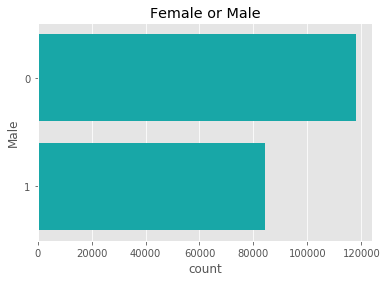

In [5]:
# Female or Male?
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.show()

In [6]:
# Recomended partition
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [7]:
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [8]:
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [9]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)
    return x



In [10]:
df_train = df_par_attr[(df_par_attr['partition'] == 0) 
                           & (df_par_attr["Male"] == 0)].sample(int(TRAINING_SAMPLES/2))

In [11]:
df_train = pd.concat([df_train,
                      df_par_attr[(df_par_attr['partition'] == 0) 
                                  & (df_par_attr["Male"] == 1)].sample(int(TRAINING_SAMPLES/2))])

In [12]:
x_train = np.array([load_reshape_img(images_folder + fname) for fname in df_train.index])


In [13]:
x_train = x_train.reshape(x_train.shape[0], 218, 178, 3)

In [14]:
import numpy as np


y_train = np.array(df_train["Male"])

In [15]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)

In [16]:
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [17]:
df_validate = df_par_attr[(df_par_attr['partition'] == 1) 
                           & (df_par_attr["Male"] == 0)].sample(int(VALIDATION_SAMPLES/2))


In [18]:

df_evaluate = pd.concat([df_validate,
                      df_par_attr[(df_par_attr['partition'] == 1) 
                                  & (df_par_attr["Male"] == 1)].sample(int(VALIDATION_SAMPLES/2))])

In [19]:
x_validate = np.array([load_reshape_img(images_folder + fname) for fname in df_evaluate.index])

In [20]:
x_validate = x_validate.reshape(x_validate.shape[0], 218, 178, 3)

In [21]:
y_validate = np.array(df_evaluate["Male"])



In [22]:
from keras.utils import to_categorical
y_validate = to_categorical(y_validate)

## Model

In [23]:
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense

model = Sequential()
model.add(Conv2D(8, (3, 3), padding="same",input_shape=(218,178,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(2, activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 218, 178, 8)       224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 59, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 59, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 29, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8064)              0         
__________

In [24]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0005),metrics=['accuracy'])
ist = model.fit_generator(train_generator
                     , validation_data = (x_validate, y_validate)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , verbose=1
                          
                    )

Epoch 1/20
625/625 [==============================] - 215s 344ms/step - loss: 0.6937 - acc: 0.4954 - val_loss: 0.6944 - val_acc: 0.4940
Epoch 2/20
625/625 [==============================] - 224s 358ms/step - loss: 0.6932 - acc: 0.4924 - val_loss: 0.6944 - val_acc: 0.5015
Epoch 3/20
625/625 [==============================] - 220s 352ms/step - loss: 0.6932 - acc: 0.4922 - val_loss: 0.6944 - val_acc: 0.5010
Epoch 4/20
625/625 [==============================] - 219s 350ms/step - loss: 0.6932 - acc: 0.5022 - val_loss: 0.6944 - val_acc: 0.4910
Epoch 5/20
625/625 [==============================] - 221s 354ms/step - loss: 0.6932 - acc: 0.4946 - val_loss: 0.6944 - val_acc: 0.4915
Epoch 6/20
625/625 [==============================] - 217s 346ms/step - loss: 0.6932 - acc: 0.4956 - val_loss: 0.6944 - val_acc: 0.4910
Epoch 7/20
625/625 [==============================] - 217s 348ms/step - loss: 0.6932 - acc: 0.4966 - val_loss: 0.6944 - val_acc: 0.4875
Epoch 8/20
625/625 [============================

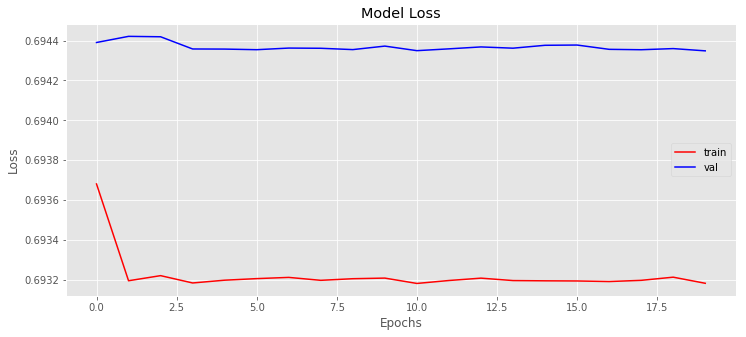

In [25]:
history = ist
# Model Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [26]:
df_test = df_par_attr[(df_par_attr['partition'] == 2) 
                           & (df_par_attr["Male"] == 0)].sample(int(TEST_SAMPLES/2))


In [27]:
df_test = pd.concat([df_test,
                      df_par_attr[(df_par_attr['partition'] == 2) 
                                  & (df_par_attr["Male"] == 1)].sample(int(TEST_SAMPLES/2))])

In [28]:
x_test = []
y_test = []
for index, target in df_test.iterrows():
    im = cv2.imread(images_folder + index)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    x_test.append(im)
    y_test.append(target["Male"])

In [29]:
model_predictions = [np.argmax(model.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 48.0500%
f1_score: 0.49440389294403897


In [30]:
# as we built the CNN from scracth and as it has no pre training, our accuracy is low. Low training data is also another reason